**Chapter– Processing Sequences Using RNNs and CNNs**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

## Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

## Computing Some Baselines

Naive predictions (just predict the last observed value):

In [5]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

Linear predictions:

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.1080 - val_loss: 0.0565
Epoch 2/20
219/219 [==============================] - 0s 872us/step - loss: 0.0348 - val_loss: 0.0241
Epoch 3/20
219/219 [==============================] - 0s 880us/step - loss: 0.0175 - val_loss: 0.0138
Epoch 4/20
219/219 [==============================] - 0s 854us/step - loss: 0.0112 - val_loss: 0.0097
Epoch 5/20
219/219 [==============================] - 0s 838us/step - loss: 0.0085 - val_loss: 0.0080
Epoch 6/20
219/219 [==============================] - 0s 854us/step - loss: 0.0072 - val_loss: 0.0069
Epoch 7/20
219/219 [==============================] - 0s 813us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 8/20
219/219 [==============================] - 0s 855us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 9/20
219/219 [==============================] - 0s 841us/step - loss: 0.0053 - val_loss: 0.0051
Epoch 10/20
219/219 [==============================] - 0s 858us/step - loss: 0.0049 

In [7]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 602us/step - loss: 0.0036


0.003618513233959675

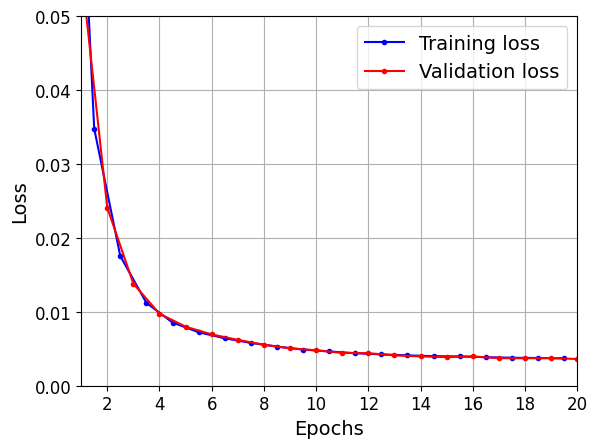

In [8]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [9]:
y_pred = model.predict(X_valid)

63/63 [==============================] - 0s 565us/step


## Using a Simple RNN

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0181 - val_loss: 0.0110
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0110

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010910107754170895

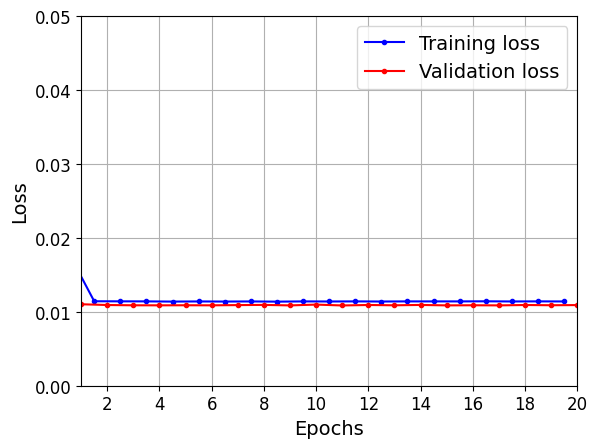

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [13]:
y_pred = model.predict(X_valid)

63/63 [==============================] - 0s 1ms/step


## Deep RNNs

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 12ms/step - loss: 0.0138 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0028 - val_lo

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0026


0.002593410201370716

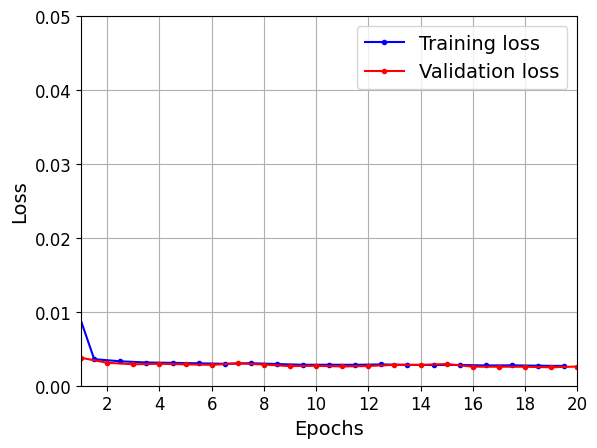

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0121 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0028

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0025


0.002470567589625716

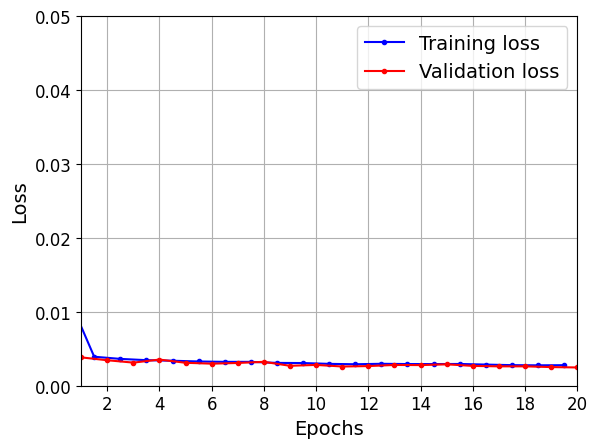

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Forecasting Several Steps Ahead

In [20]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 15ms/step


In [21]:
Y_pred.shape

(1, 10, 1)

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [22]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [23]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 2ms/step


In [24]:
Y_pred.shape

(2000, 10)

In [25]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.01995637

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [26]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1272 - val_loss: 0.0706
Epoch 2/20
219/219 [==============================] - 0s 843us/step - loss: 0.0572 - val_loss: 0.0486
Epoch 3/20
219/219 [==============================] - 0s 834us/step - loss: 0.0427 - val_loss: 0.0388
Epoch 4/20
219/219 [==============================] - 0s 849us/step - loss: 0.0358 - val_loss: 0.0336
Epoch 5/20
219/219 [==============================] - 0s 851us/step - loss: 0.0317 - val_loss: 0.0303
Epoch 6/20
219/219 [==============================] - 0s 834us/step - loss: 0.0290 - val_loss: 0.0282
Epoch 7/20
219/219 [==============================] - 0s 854us/step - loss: 0.0271 - val_loss: 0.0264
Epoch 8/20
219/219 [==============================] - 0s 834us/step - loss: 0.0257 - val_loss: 0.0250
Epoch 9/20
219/219 [==============================] - 0s 849us/step - loss: 0.0246 - val_loss: 0.0240
Epoch 10/20
219/219 [==============================] - 0s 831us/step - loss: 0.0236 

Now let's create an RNN that predicts all 10 next values at once:

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0559 - val_loss: 0.0294
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0222 - val_loss: 0.0184
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0163 - val_loss: 0.0140
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0133 - val_loss: 0.0112
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 0.0104
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 9/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 10/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0102 - val_loss: 0.0090

In [29]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 136ms/step


Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [30]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [31]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0475 - last_time_step_mse: 0.0364 - val_loss: 0.0361 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0365 - last_time_step_mse: 0.0245 - val_loss: 0.0363 - val_last_time_step_mse: 0.0259
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0310 - last_time_step_mse: 0.0183 - val_loss: 0.0299 - val_last_time_step_mse: 0.0178
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0278 - last_time_step_mse: 0.0144 - val_loss: 0.0245 - val_last_time_step_mse: 0.0106
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0249 - last_time_step_mse: 0.0110 - val_loss: 0.0227 - val_last_time_step_mse: 0.0088
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0234 - last_time_step_mse: 0.0099 - val_loss: 0.0228 - val_last_time_step_mse: 0.0095
Epoch 7/20
219/219 [========

In [33]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 142ms/step


# Deep RNN with Batch Norm

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

# Deep RNNs with Layer Norm

In [35]:
from tensorflow.keras.layers import LayerNormalization

In [36]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.1259 - last_time_step_mse: 0.1058 - val_loss: 0.0679 - val_last_time_step_mse: 0.0561
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0620 - last_time_step_mse: 0.0513 - val_loss: 0.0565 - val_last_time_step_mse: 0.0459
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0540 - last_time_step_mse: 0.0435 - val_loss: 0.0510 - val_last_time_step_mse: 0.0405
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0490 - last_time_step_mse: 0.0386 - val_loss: 0.0461 - val_last_time_step_mse: 0.0358
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0449 - last_time_step_mse: 0.0348 - val_loss: 0.0430 - val_last_time_step_mse: 0.0333
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0419 - last_time_step_mse: 0.0323 - val_loss: 0.0396 - val_last_time_step_mse: 0.0303
Epoch 7/20
219/219 [==

# Creating a Custom RNN Class

In [38]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.1483 - last_time_step_mse: 0.1229 - val_loss: 0.0716 - val_last_time_step_mse: 0.0529
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0616 - last_time_step_mse: 0.0479 - val_loss: 0.0559 - val_last_time_step_mse: 0.0442
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0522 - last_time_step_mse: 0.0407 - val_loss: 0.0495 - val_last_time_step_mse: 0.0377
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0471 - last_time_step_mse: 0.0371 - val_loss: 0.0443 - val_last_time_step_mse: 0.0343
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0427 - last_time_step_mse: 0.0317 - val_loss: 0.0402 - val_last_time_step_mse: 0.0276
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0389 - last_time_step_mse: 0.0257 - val_loss: 0.0370 - val_last_time_step_mse: 0.0227
Epoch 7/20
219/219 [==

# LSTMs

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.0784 - last_time_step_mse: 0.0641 - val_loss: 0.0549 - val_last_time_step_mse: 0.0352
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0472 - last_time_step_mse: 0.0265 - val_loss: 0.0418 - val_last_time_step_mse: 0.0210
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0384 - last_time_step_mse: 0.0174 - val_loss: 0.0371 - val_last_time_step_mse: 0.0170
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0350 - last_time_step_mse: 0.0155 - val_loss: 0.0338 - val_last_time_step_mse: 0.0144
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0332 - last_time_step_mse: 0.0148 - val_loss: 0.0326 - val_last_time_step_mse: 0.0142
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0316 - last_time_step_mse: 0.0137 - val_loss: 0.0307 - val_last_time_step_mse: 0.0128
Epoch 7/20
219/219 [==

In [41]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0241 - last_time_step_mse: 0.0086


[0.02412364073097706, 0.008634794503450394]

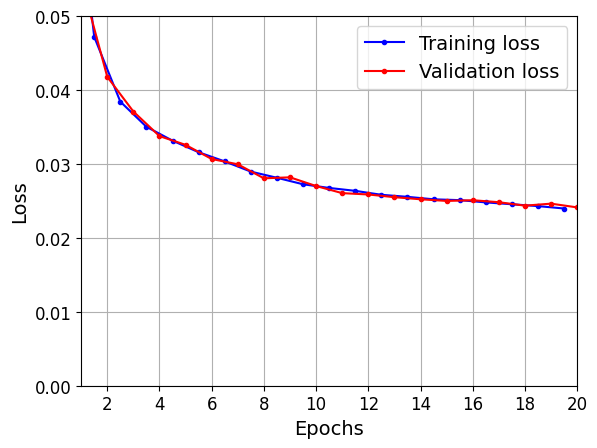

In [42]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [43]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 465ms/step


# GRUs

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 15ms/step - loss: 0.0754 - last_time_step_mse: 0.0661 - val_loss: 0.0559 - val_last_time_step_mse: 0.0449
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0505 - last_time_step_mse: 0.0400 - val_loss: 0.0464 - val_last_time_step_mse: 0.0358
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0447 - last_time_step_mse: 0.0338 - val_loss: 0.0426 - val_last_time_step_mse: 0.0319
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0412 - last_time_step_mse: 0.0298 - val_loss: 0.0390 - val_last_time_step_mse: 0.0266
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0382 - last_time_step_mse: 0.0260 - val_loss: 0.0367 - val_last_time_step_mse: 0.0252
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0359 - last_time_step_mse: 0.0233 - val_loss: 0.0341 - val_last_time_step_mse: 0.0208
Epoch 7/20
219/219 [==

In [46]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0230 - last_time_step_mse: 0.0092


[0.02302752248942852, 0.0091557577252388]

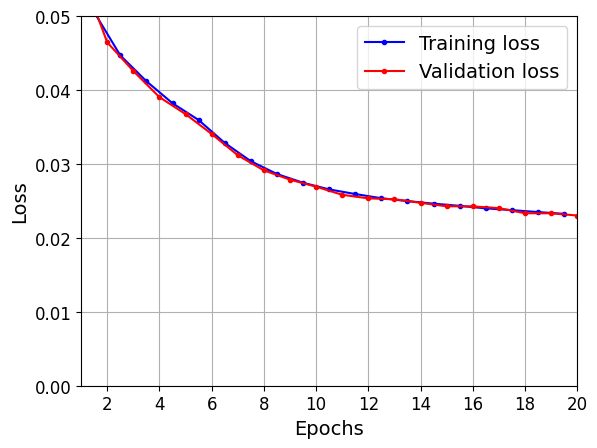

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [48]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 434ms/step


## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.0663 - last_time_step_mse: 0.0579 - val_loss: 0.0436 - val_last_time_step_mse: 0.0345
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0385 - last_time_step_mse: 0.0307 - val_loss: 0.0331 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0300 - last_time_step_mse: 0.0207 - val_loss: 0.0274 - val_last_time_step_mse: 0.0167
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0258 - last_time_step_mse: 0.0148 - val_loss: 0.0246 - val_last_time_step_mse: 0.0136
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0240 - last_time_step_mse: 0.0128 - val_loss: 0.0240 - val_last_time_step_mse: 0.0131
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0229 - last_time_step_mse: 0.0118 - val_loss: 0.0224 - val_last_time_step_mse: 0.0111
Epoch 7/20
219/219 [=======

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0693 - last_time_step_mse: 0.0572 - val_loss: 0.0361 - val_last_time_step_mse: 0.0217
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0325 - last_time_step_mse: 0.0189 - val_loss: 0.0295 - val_last_time_step_mse: 0.0164
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0284 - last_time_step_mse: 0.0155 - val_loss: 0.0269 - val_last_time_step_mse: 0.0143
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0263 - last_time_step_mse: 0.0137 - val_loss: 0.0258 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0252 - last_time_step_mse: 0.0128 - val_loss: 0.0245 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0243 - last_time_step_mse: 0.0119 - val_loss: 0.0238 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [========

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.